# Imports

In [16]:
# !pip install datasets -q
# from datasets import list_datasets, load_dataset

In [99]:
# libs
import numpy as np
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# data
from sklearn import datasets


# Load

In [95]:
data = datasets.fetch_california_housing(as_frame=True).frame.sample(frac=0.5)
print(data.shape)
data[:3]

(10320, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
12718,6.8469,36.0,8.734266,1.111888,362.0,2.531469,38.60,-121.38,4.464
14045,2.0792,35.0,3.527668,0.974308,965.0,1.907115,32.76,-117.14,1.600
1623,7.3267,27.0,7.208038,1.005516,3371.0,2.656422,37.85,-122.14,3.899


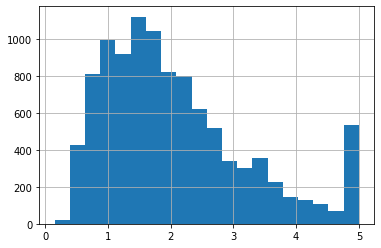

In [97]:
data['MedHouseVal'].hist(bins=20)

In [98]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
MedInc,10320.0,3.871272,1.882734,0.499900,2.566400,3.529450,4.764100,15.000100
HouseAge,10320.0,28.563953,12.535705,1.000000,18.000000,29.000000,37.000000,52.000000
AveRooms,10320.0,5.406346,1.980537,0.846154,4.442179,5.224934,6.051620,61.812500
AveBedrms,10320.0,1.089676,0.338147,0.333333,1.004759,1.047619,1.097561,11.000000
Population,10320.0,1435.094089,1143.276249,5.000000,792.000000,1168.000000,1742.000000,35682.000000
AveOccup,10320.0,3.143497,13.773622,0.692308,2.433546,2.819478,3.279135,1243.333333
Latitude,10320.0,35.638237,2.155225,32.550000,33.930000,34.250000,37.730000,41.950000
Longitude,10320.0,-119.576441,2.011301,-124.350000,-121.810000,-118.500000,-118.010000,-114.310000
MedHouseVal,10320.0,2.067196,1.149138,0.149990,1.194000,1.804000,2.648250,5.000010


In [21]:
x_cols = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
y_col = 'MedHouseVal'
X_df = data[x_cols]
Y_sr = data[y_col]

In [77]:
X_train_df, X_test_df, Y_train_sr, Y_test_sr = train_test_split(
    X_df, Y_sr, 
    test_size=0.33, 
    random_state=42
)

In [100]:
x_scaler = preprocessing.StandardScaler()
X_tr_scaled = x_scaler.fit_transform(X_train_df)
X_te_scaled = x_scaler.transform(X_test_df)

In [101]:
class Data(Dataset):

    def __init__(self, X_train, y_train):
        # need to convert float64 to float32 else 
        # will get the following error
        # RuntimeError: expected scalar type Double but found Float
        self.X = torch.from_numpy(X_train).type(torch.FloatTensor)
        # need to convert float64 to Long else 
        # will get the following error
        # RuntimeError: expected scalar type Long but found Float
        self.y = torch.from_numpy(y_train).type(torch.FloatTensor)
        self.len = self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.len

In [103]:
train_data = Data(X_tr_scaled, Y_train_sr.values)

In [104]:
batch_size = 32
trainloader = DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=2
)

# Model

In [105]:
# number of features (len of X cols)
input_dim = len(x_cols)
# number of hidden layers
hidden_layers = 25
# number of classes (unique of y)
output_dim = 1

In [106]:
class Network(nn.Module):

    def __init__(self):
        super(Network, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_layers)
        self.linear2 = nn.Linear(hidden_layers, output_dim)

    def forward(self, x):
        x = torch.sigmoid(self.linear1(x))
        x = self.linear2(x)
        return x


In [107]:
model = Network()

In [108]:
model

Network(
  (linear1): Linear(in_features=8, out_features=25, bias=True)
  (linear2): Linear(in_features=25, out_features=1, bias=True)
)

In [109]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [123]:
epochs = 100
for epoch in range(epochs):
    losses = []
    for i, data in enumerate(trainloader):
        inputs, labels = data
        labels = labels.unsqueeze(1)
        # set optimizer to zero grad to remove previous epoch gradients
        optimizer.zero_grad()
        # forward propagation
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # backward propagation
        loss.backward()
        # optimize
        optimizer.step()
        losses += [loss.item()]
    # display statistics
    if (epoch + 1) % 10 == 0:
        print(f'[{epoch + 1}, {i + 1:5d}] loss: {np.mean(losses) :.3f}')

[10,   217] loss: 0.911
[20,   217] loss: 0.669
[30,   217] loss: 0.601
[40,   217] loss: 0.577
[50,   217] loss: 0.578
[60,   217] loss: 0.555
[70,   217] loss: 0.544
[80,   217] loss: 0.534
[90,   217] loss: 0.528
[100,   217] loss: 0.519
